In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
model_version = 'v14.0'

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [11]:
df = pd.read_csv(f"../data/processed/spectrometry_photometry.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.BatchNormalization(name='BN_64')(x)
x = layers.Activation('relu', name='Act_64')(x)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.BatchNormalization(name='BN_128')(x)
x = layers.Activation('relu', name='Act_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.BatchNormalization(name='BN_256')(x)
x = layers.Activation('relu', name='Act_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.BatchNormalization(name='BN_128_2')(x)
x = layers.Activation('relu', name='Act_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 24)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                1600      
                                                                 
 BN_64 (BatchNormalization)  (None, 64)                256       
                                                                 
 Act_64 (Activation)         (None, 64)                0         
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 BN_128 (BatchNormalization)  (None, 128)         

In [15]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.5,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2443/2443 [==============================] - 27s 11ms/step - loss: 4.7559 - mae: 1.2657 - mse: 4.2923 - mape: 11.9977 - val_loss: 0.6570 - val_mae: 0.2906 - val_mse: 0.2140 - val_mape: 2.8694
Epoch 2/200
2443/2443 [==============================] - 24s 10ms/step - loss: 1.1404 - mae: 0.6828 - mse: 0.7453 - mape: 6.4915 - val_loss: 0.4273 - val_mae: 0.1955 - val_mse: 0.0903 - val_mape: 1.9019
Epoch 3/200
2443/2443 [==============================] - 25s 10ms/step - loss: 0.8028 - mae: 0.5771 - mse: 0.5310 - mape: 5.4934 - val_loss: 0.2968 - val_mae: 0.2046 - val_mse: 0.0846 - val_mape: 1.9729
Epoch 4/200
2443/2443 [==============================] - 25s 10ms/step - loss: 0.6049 - mae: 0.5208 - mse: 0.4360 - mape: 4.9624 - val_loss: 0.2423 - val_mae: 0.2499 - val_mse: 0.1111 - val_mape: 2.3976
Epoch 5/200
2443/2443 [==============================] - 25s 10ms/step - loss: 0.4749 - mae: 0.4744 - mse: 0.3641 - mape: 4.5212 - val_loss: 0.1983 - val_mae: 0.2348 - val_mse: 0.1052 - v

In [16]:
model.save(f'../models/{model_version}/photo_no_transfer_model.h5')

In [17]:
save_history(history, model_version)

In [18]:
y_pred_full = model.predict(X_test_scaled)

2094/2094 [==============================] - 6s 3ms/step


In [19]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0897
Root Mean Squared Error (RMSE): 0.1688
R² Score: 0.9340


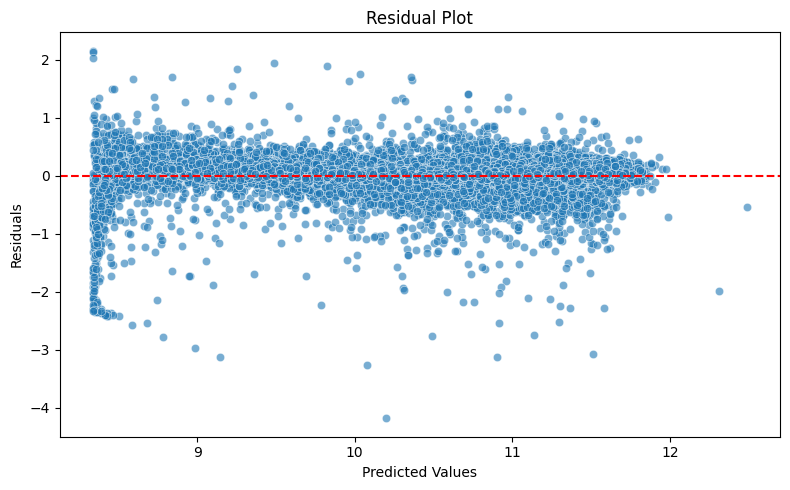

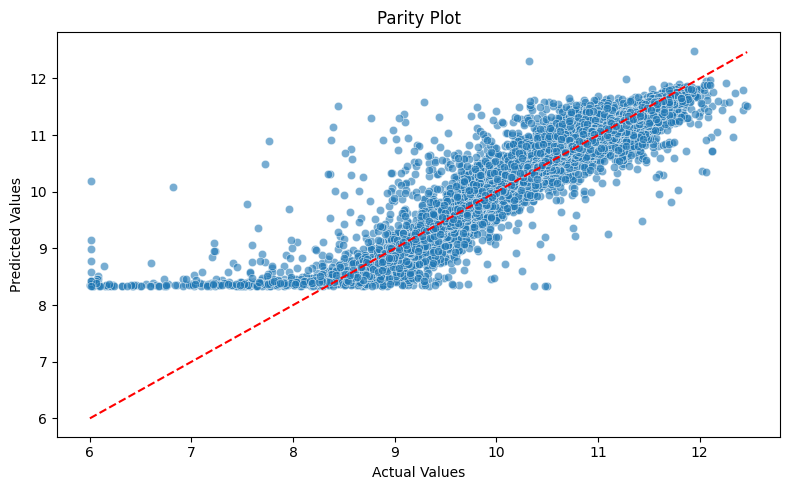

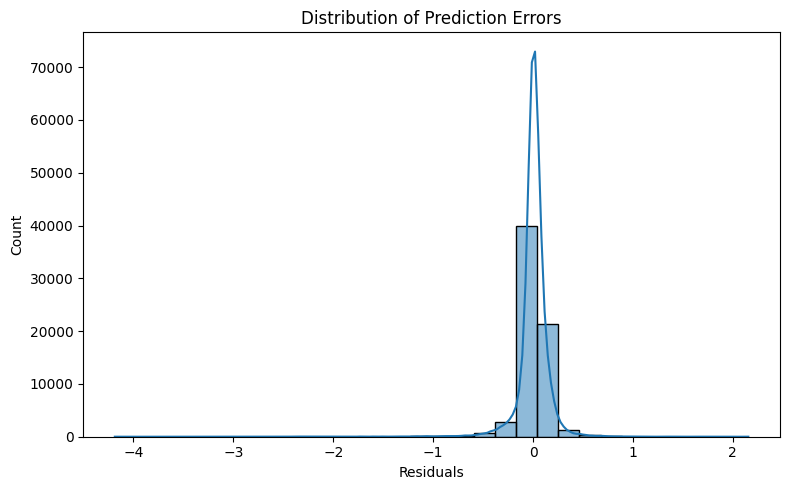

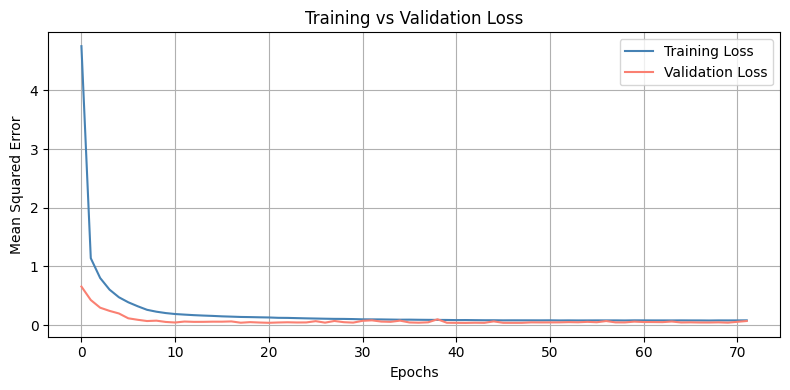

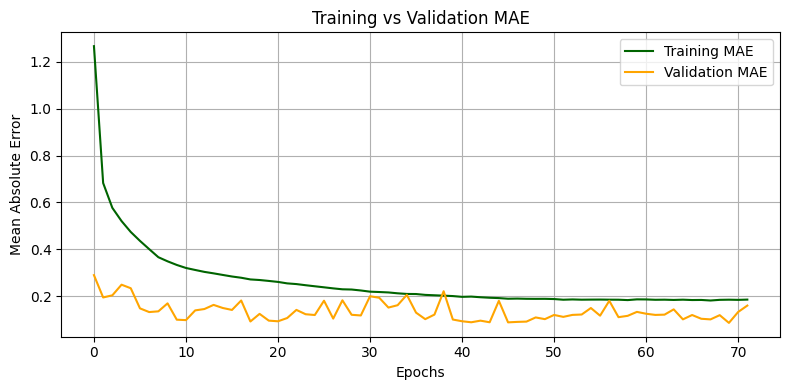

: 

In [ ]:
plot_visualizations(history, y_test, y_pred_full)

In [16]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[spectro_cols + photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [17]:
X_unseen_scaled = scaler.transform(X_unseen)

In [18]:
y_pred_unseen = model.predict(X_unseen_scaled)

6980/6980 [==============================] - 13s 2ms/step


In [19]:
plot_metrics(y_unseen, y_pred_unseen)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0827
Root Mean Squared Error (RMSE): 0.4197
R² Score: 0.5883


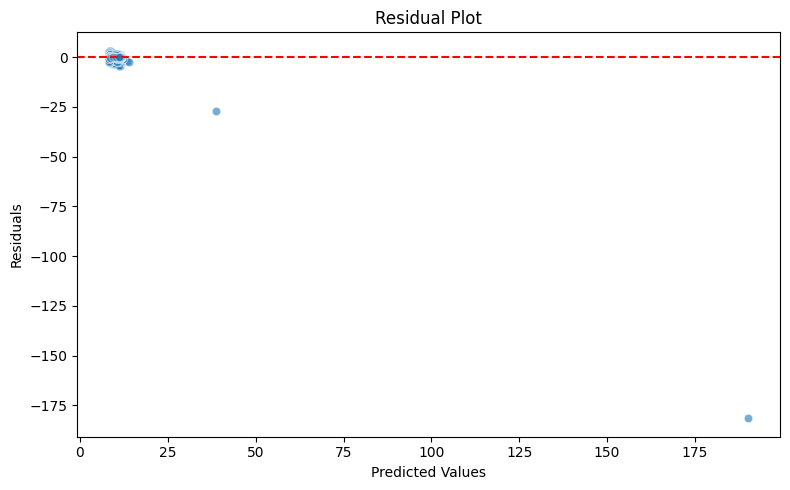

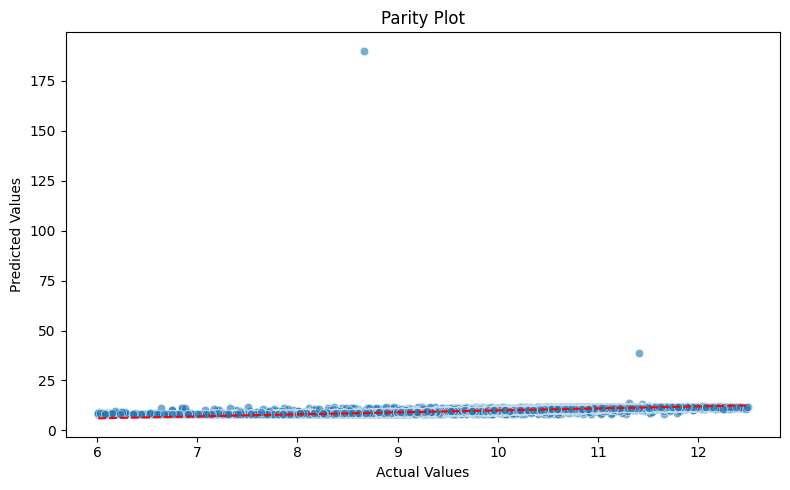

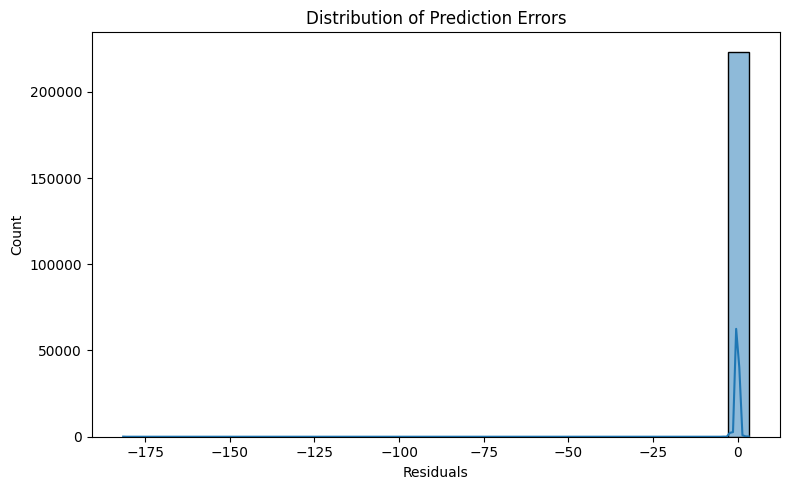

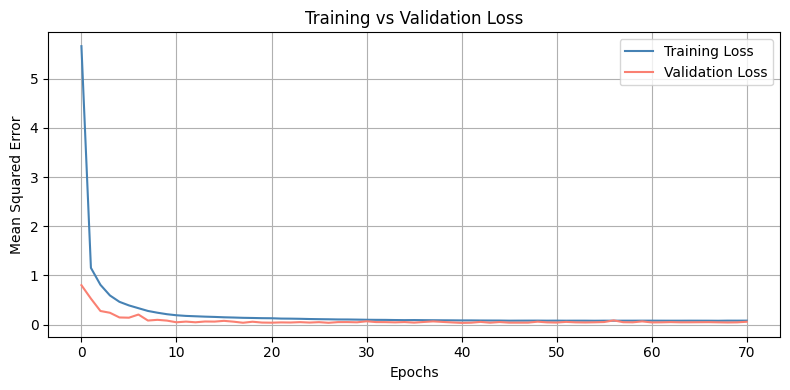

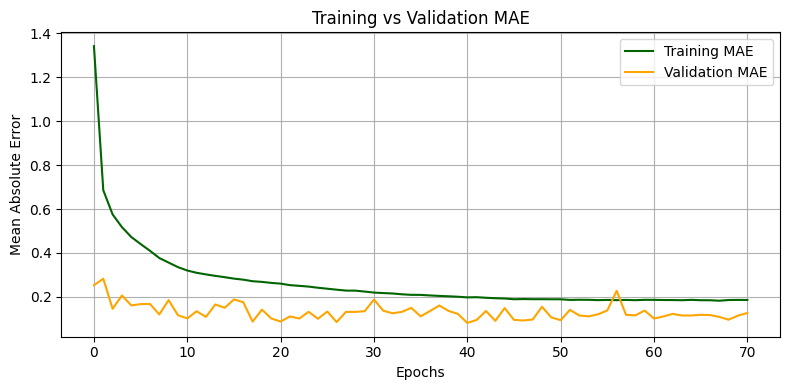

In [20]:
plot_visualizations(history, y_unseen, y_pred_unseen)